In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
import scipy as sp
from sklearn.linear_model import LinearRegression

In [ ]:
participant_data = pd.read_csv('/redacted/path/demographics.csv')
age = np.array(participant_data.age)
sex = np.array(participant_data.sex)
participantid = np.array(participant_data.ID)

In [ ]:
metrics = ['fneurite','fsoma','fe','R','ODI','b500_1200_MD']
hemi = ['L','R']
metrichold = np.empty((7262,2,len(participantid),len(metrics)))

### Load all surface data

In [ ]:
for ii in range(len(participantid)):
    for jj in range(len(hemi)):
        for kk in range(len(metrics)):
            if metrics[kk] == 'ODI':
                metrichold[:,jj,ii,kk] = nib.load(f'/redacted/path/NODDI/sub-{participantid[ii]}/midsurf/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_midthickness_desc-{metrics[kk]}.shape.gii').agg_data()                   
            elif metrics[kk] == 'b500_1200_MD':
                metrichold[:,jj,ii,kk] = nib.load(f'/redacted/path/DTI/sub-{participantid[ii]}/DTI_b500_1200/midsurf/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_midthickness_desc-{metrics[kk]}.shape.gii').agg_data()     
            else: 
                metrichold[:,jj,ii,kk] = nib.load(f'/redacted/path/SANDI/sub-{participantid[ii]}/midsurf/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_midthickness_desc-{metrics[kk]}.shape.gii').agg_data()

### Average within Ant-Post parcellations

In [ ]:
# Using JDparc25 atlas, 25 labels, where mapping is as follows: 1-5 subiculum, 6-10 CA1, 11-15 is CA2, 16-20 is CA3, and 21-25 is DG/CA4 
# Then within each range, first number is anterior and last is posterior, ex in subiculum 1 is anterior and 5 is post, and CA1 6 ant 10 post
# Took this labelling to then make an atlas file which averages across subfields to just get ant-post segmentations

APparcL = nib.load(f'/redacted/path/deriv/hippunfold/reference_hemi-L_Ant_to_Post_5bins.shape.gii').agg_data()
APparcR = nib.load(f'/redacted/path/deriv/hippunfold/reference_hemi-R_Ant_to_Post_5bins.shape.gii').agg_data()

APnum = np.linspace(1,5,5)

metricAPavg = np.empty((len(hemi),len(participantid),len(metrics),len(APnum)))

for ii in range(len(APnum)):
    APLind = APparcL == APnum[ii]
    APRind = APparcR == APnum[ii]

    metricAPavg[0,:,:,ii] = np.mean(metrichold[APLind,0,:,:],axis=0)
    metricAPavg[1,:,:,ii] = np.mean(metrichold[APRind,1,:,:],axis=0)

### Make dataframe

In [7]:
dL = {}
dR = {}
for ii in range(len(metrics)):
    dL[metrics[ii]] = metricAPavg[0,:,ii,:].flatten(order='F')
    dR[metrics[ii]] = metricAPavg[1,:,ii,:].flatten(order='F')

dL['age'] = np.tile(age,5)
dL['participantid'] = np.tile(participantid,5)
dL['sex'] = np.tile(sex,5)
dL['hemi'] = np.repeat(hemi[0],88*5)

dR['age'] = np.tile(age,5)
dR['participantid'] = np.tile(participantid,5)
dR['sex'] = np.tile(sex,5)
dR['hemi'] = np.repeat(hemi[1],88*5)

label = np.empty((88*5))

for ii in range(5):
    first = 88*(ii)
    last = 88*(ii+1)
    label[first:last] = ii+1

dL['APbin'] = label
dR['APbin'] = label

label = np.empty((88*5),dtype=object)
label[0:88] = 'Anterior uncus'
label[88:88*2] = 'Anterior lateral'
label[88*2:88*3] = 'Body anterior'
label[88*3:88*4] = 'Body posterior'
label[88*4:88*5] = 'Posterior'
dL['AP_labels'] = label
dR['AP_labels'] = label

dfL = pd.DataFrame(data=dL)
dfR = pd.DataFrame(data=dR)

frames = [dfL, dfR]

dfcombAP = pd.concat(frames)

In [ ]:
dfAPplot = pd.melt(dfcombAP,id_vars=['age','APbin','AP_labels','participantid','hemi','sex'])

### Averaging hemispheres

In [ ]:
df = {}
for ii in range(len(metrics)):
    df[metrics[ii]] = np.mean(metricAPavg[:,:,ii,:],axis=0).flatten(order='F')


df['age'] = np.tile(age,5)
df['participantid'] = np.tile(participantid,5)
df['sex'] = np.tile(sex,5)

label = np.empty((88*5))
label[0:88] = 1
label[88:88*2] = 2
label[88*2:88*3] = 3
label[88*3:88*4] = 4
label[88*4:88*5] = 5
df['APbin'] = label

label = np.empty((88*5),dtype=object)
label[0:88] = 'Anterior uncus'
label[88:88*2] = 'Anterior lateral'
label[88*2:88*3] = 'Body anterior'
label[88*3:88*4] = 'Body posterior'
label[88*4:88*5] = 'Posterior'
df['AP_labels'] = label

dfcomb = pd.DataFrame(data=df)

In [ ]:
dfcomb['b500_1200_MD'] = dfcomb['b500_1200_MD'] * 1000 # put into um^2/ms

### This is the data in the dataset excel sheet provided with the manuscript

In [ ]:
dfplot = pd.melt(dfcomb,id_vars=['age','APbin','participantid','sex','AP_labels'])

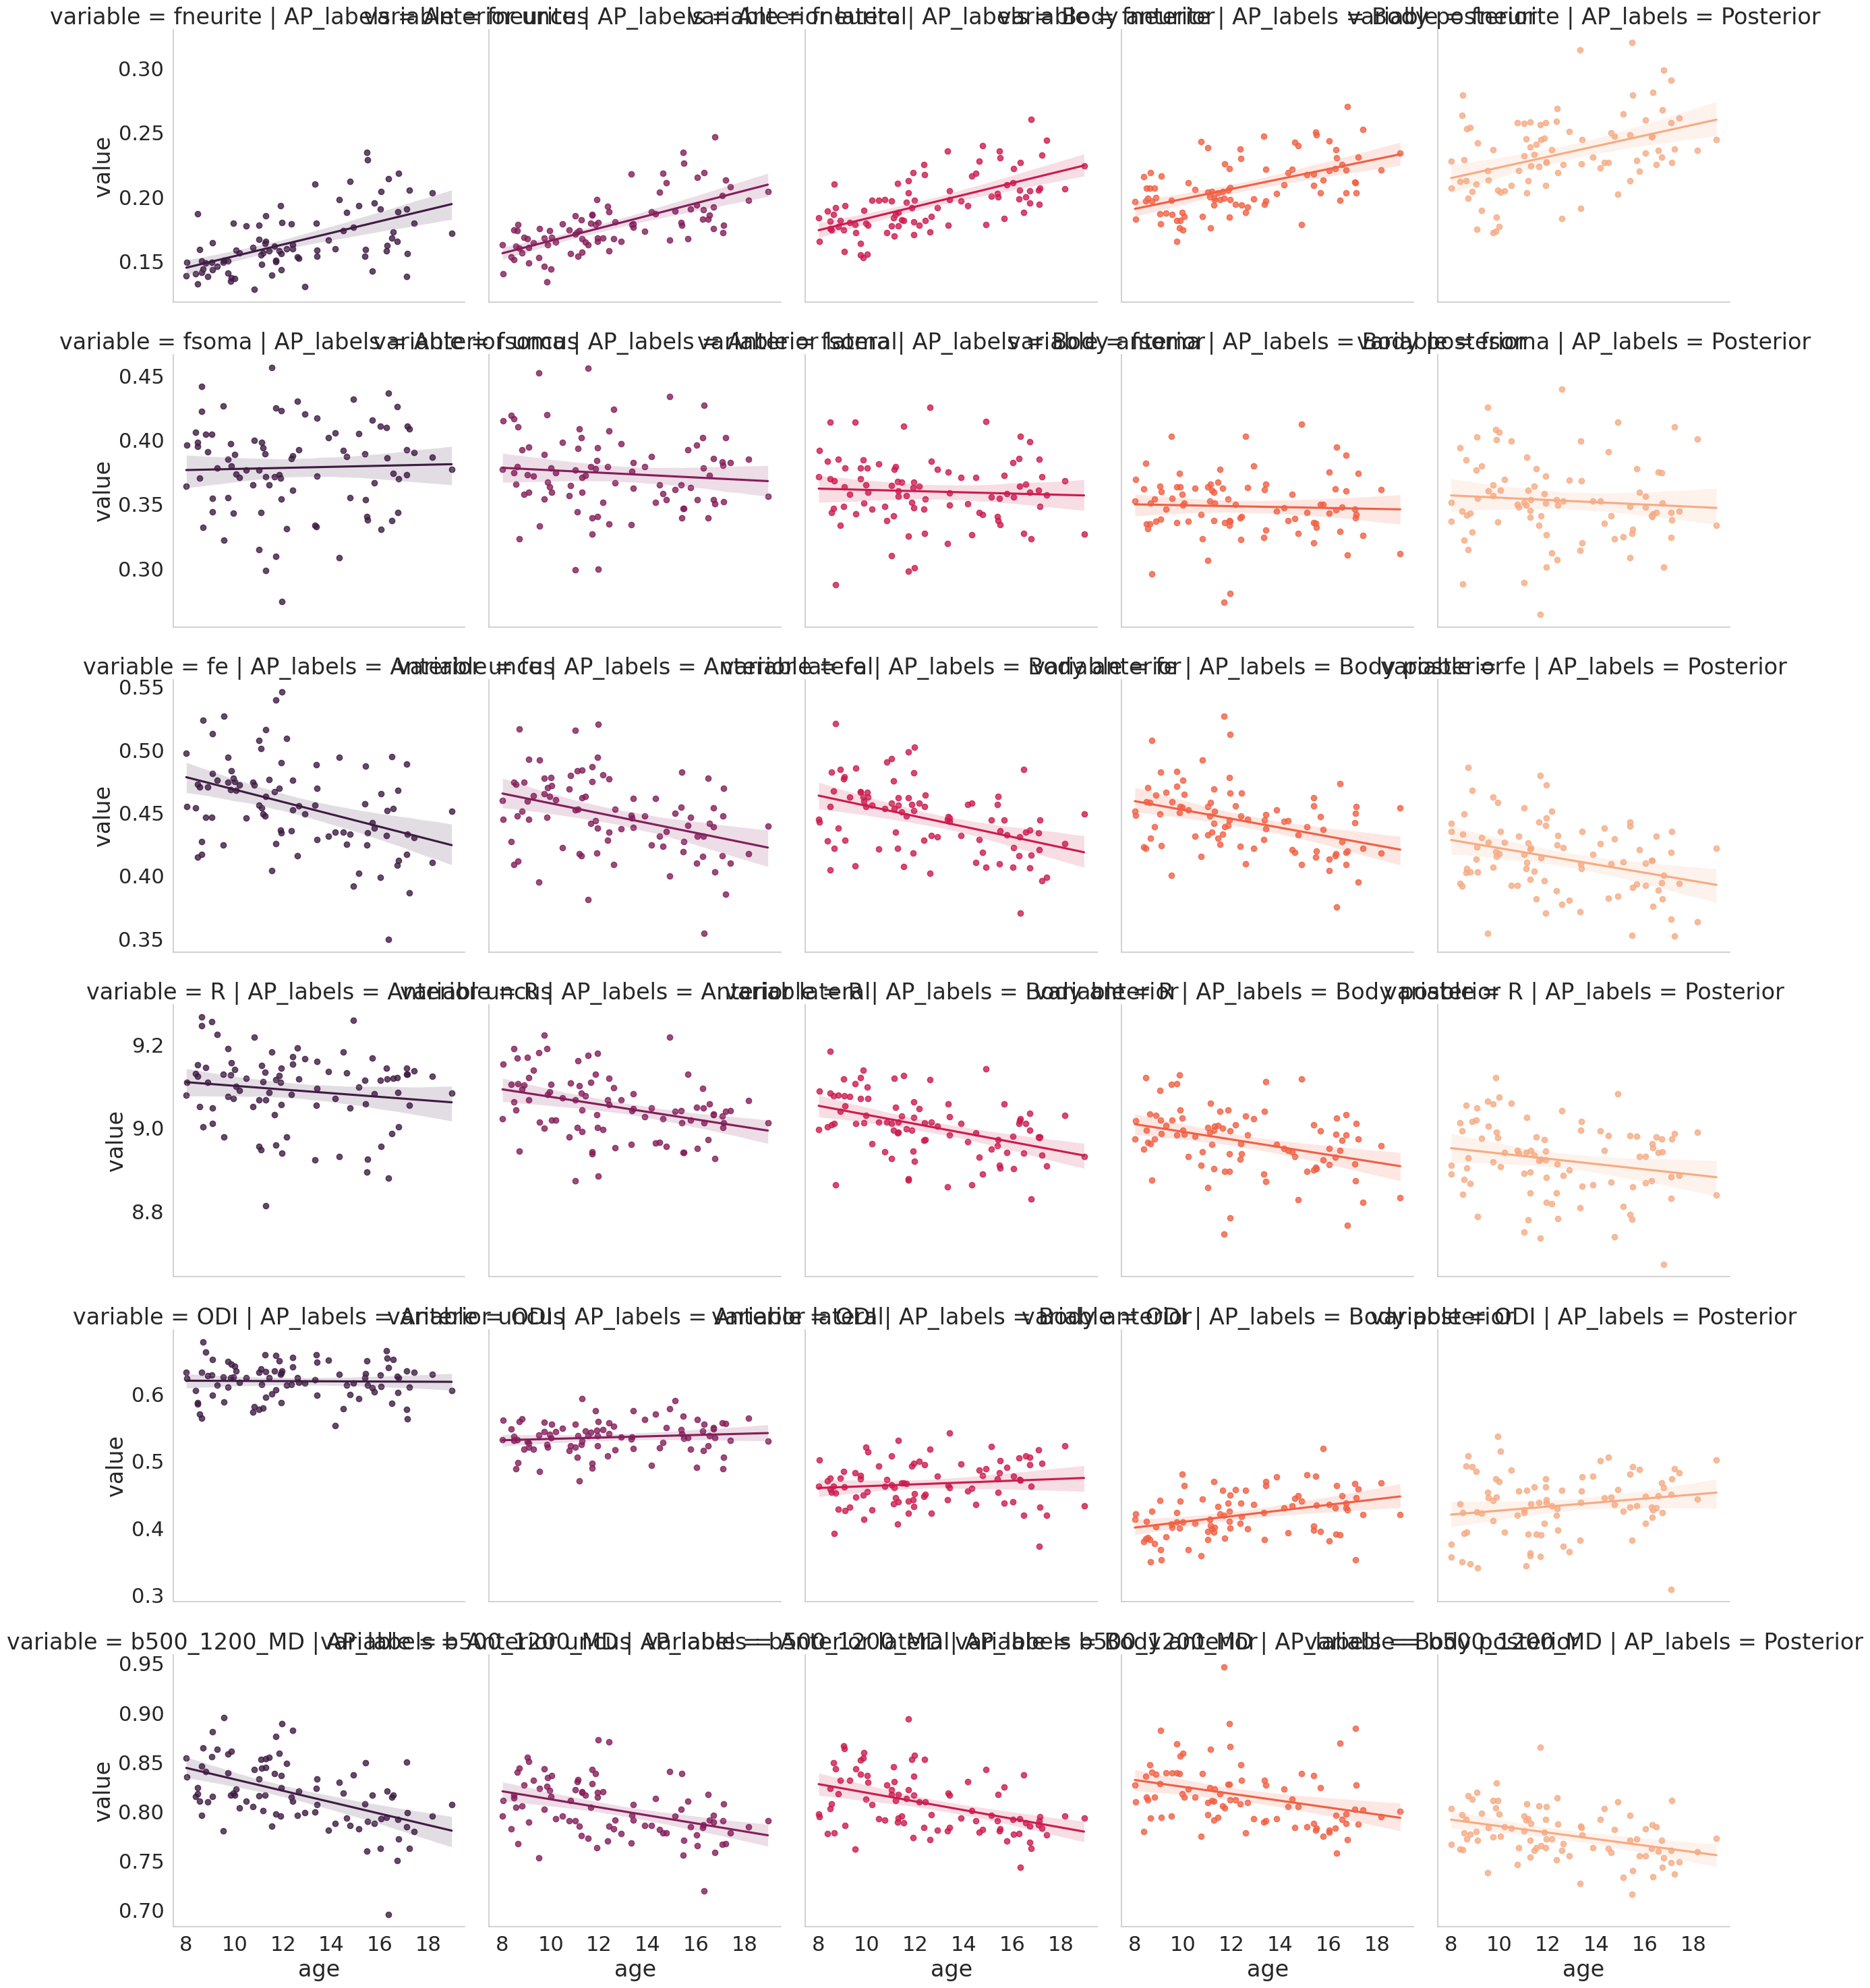

In [ ]:
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})

lm = sns.lmplot(x="age", y='value', data=dfplot,row='variable',col='AP_labels',hue='AP_labels',palette=sns.color_palette(f'rocket', n_colors=5),order=1,facet_kws={'sharey':'row','sharex':True})
plt.xticks([8,10,12,14,16,18]) 
plt.show()


# Pearson's R of metric with age

In [ ]:
metrics = ['fneurite','fsoma','fe','R','ODI','b500_1200_MD']
Rhold = np.empty((5,len(metrics)))
phold = np.empty((5,len(metrics)))

labels = ['Anterior uncus','Anterior lateral','Body anterior','Body posterior','Posterior']

for ii in range(5):
    for jj in range(len(metrics)):
        Y = dfcomb[dfcomb['APbin']==ii+1][metrics[jj]]
        X = dfcomb[dfcomb['APbin']==ii+1]['age']
        corr = sp.stats.pearsonr(X,Y)
        Rhold[ii,jj]= corr[0]
        phold[ii,jj]= corr[1]

<Axes: >

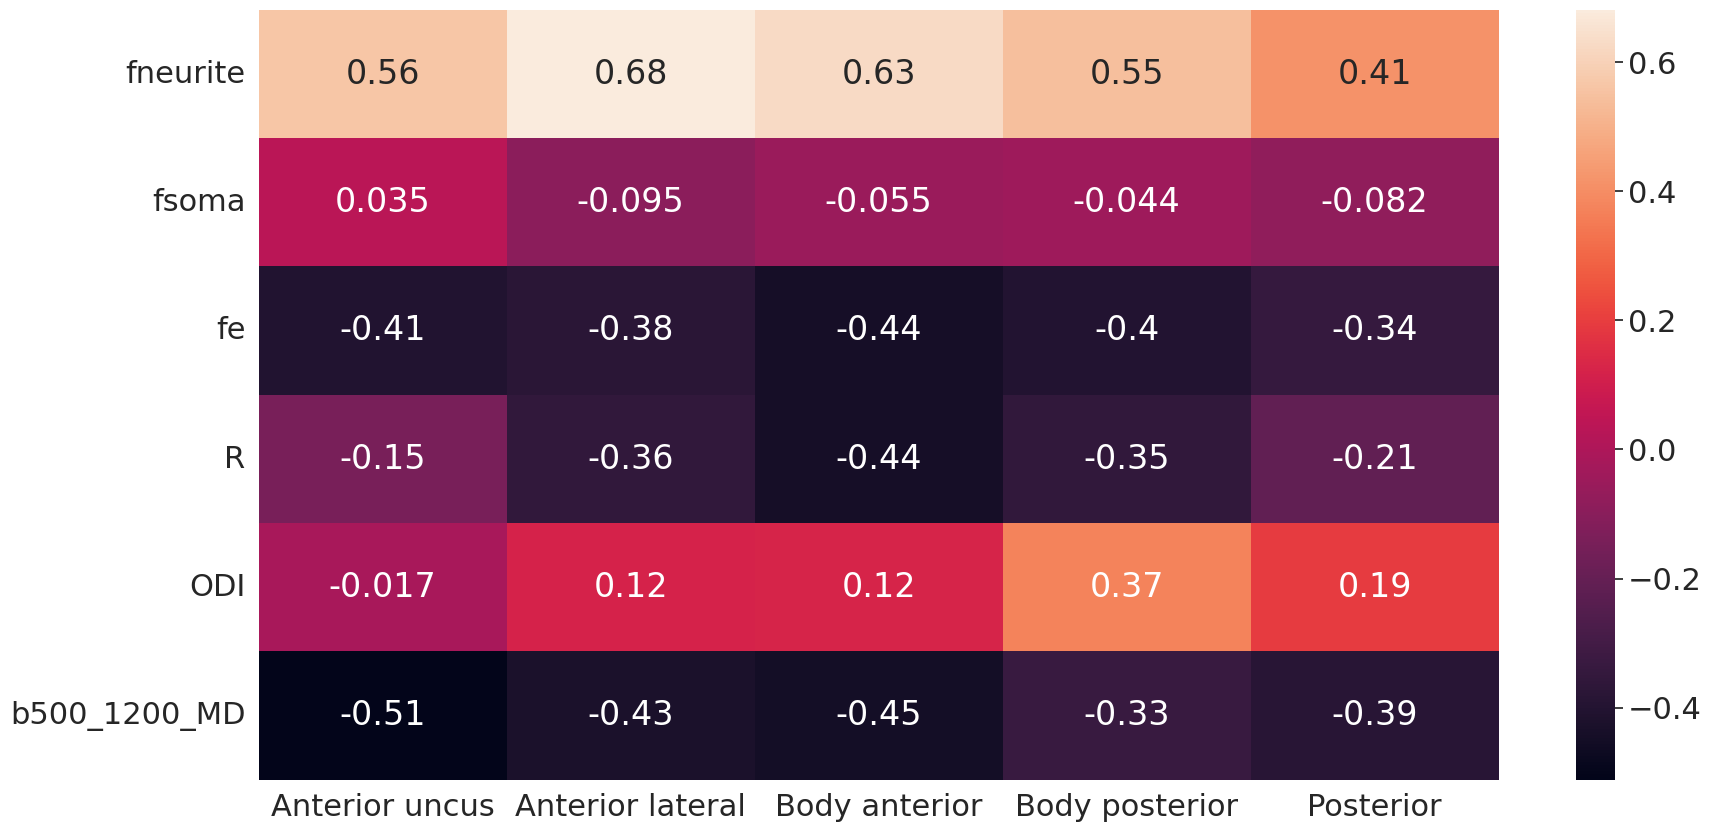

In [20]:
fig, ax = plt.subplots(figsize=(20,10))

Rdf = pd.DataFrame(Rhold.T)

sns.heatmap(Rdf,annot=True,yticklabels=metrics,xticklabels=labels)

### p-value of Pearson's R (is R sig. > 0)

<Axes: >

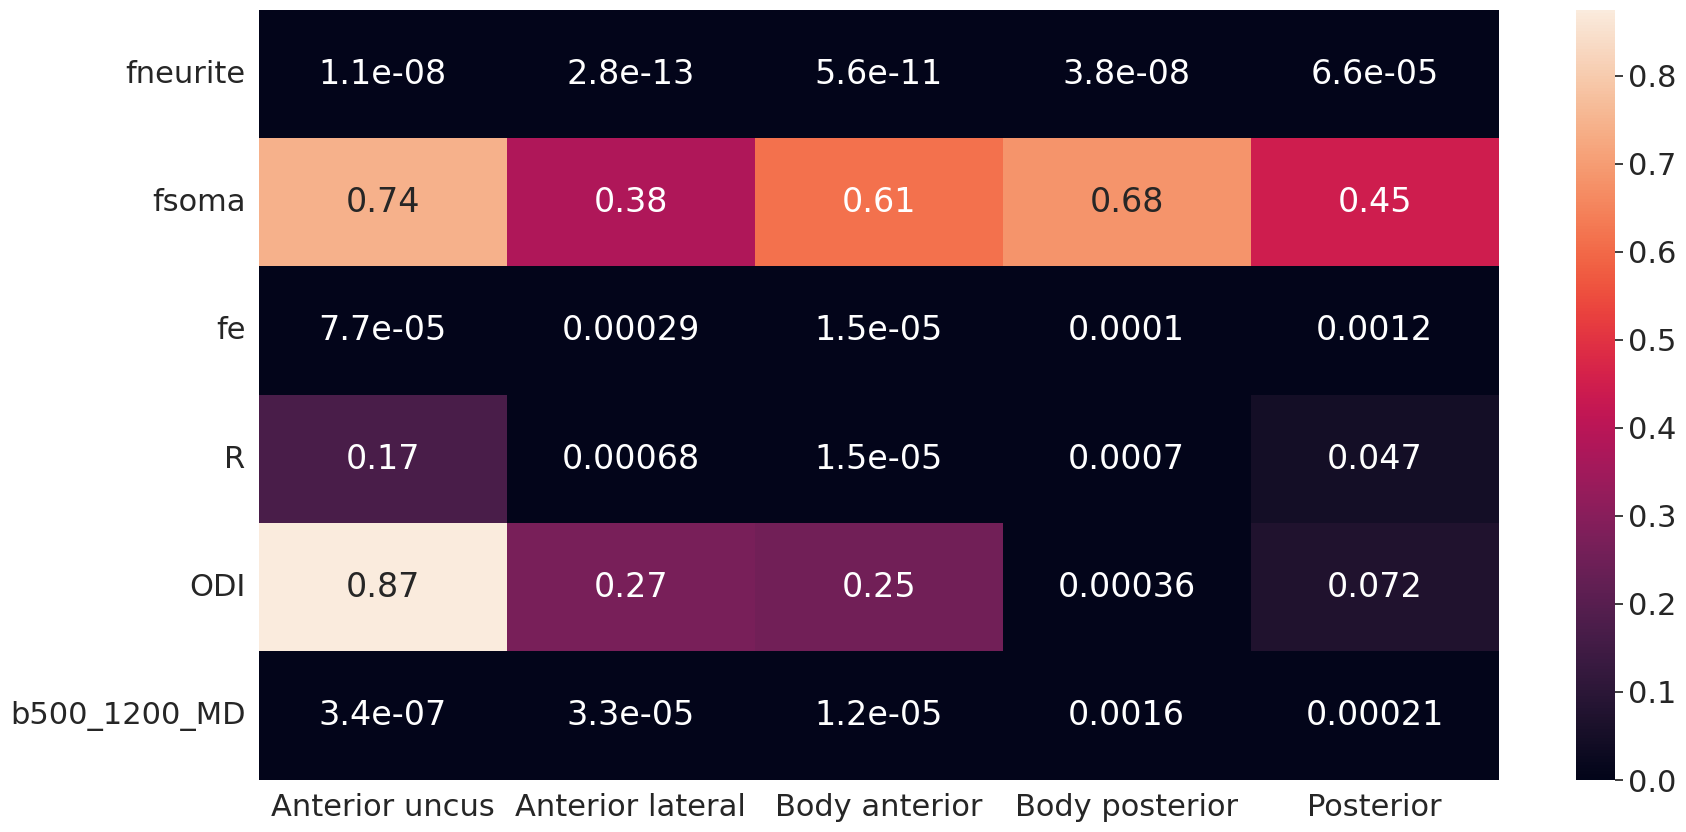

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
pval = pd.DataFrame(phold.T)
sns.heatmap(pval,annot=True,yticklabels=metrics,xticklabels=labels)

### AP slope across age comparison (are the slopes different AP)

In [16]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='fneurite ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='fneurite ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.123071      0.0       NaN       NaN       NaN
1     424.0  0.122697      4.0  0.000374  0.323366  0.862301


In [17]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='fsoma ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='fsoma ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.350168      0.0       NaN       NaN       NaN
1     424.0  0.349206      4.0  0.000962  0.292048  0.883122


In [18]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='fe ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='fe ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff  ss_diff         F    Pr(>F)
0     428.0  0.316382      0.0      NaN       NaN       NaN
1     424.0  0.315272      4.0  0.00111  0.373364  0.827643


In [19]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='R ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='R ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  2.242003      0.0       NaN       NaN       NaN
1     424.0  2.225127      4.0  0.016876  0.803943  0.523127


In [20]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='ODI ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='ODI ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.451702      0.0       NaN       NaN       NaN
1     424.0  0.443114      4.0  0.008588  2.054417  0.085952


In [28]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

#lm1 = smf.ols(formula='b1200_MD ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
#lm2 = smf.ols(formula='b1200_MD ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()
lm1 = smf.ols(formula='b500_1200_MD ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='b500_1200_MD ~ age + C(sex) + C(AP_labels) + age:C(sex) + C(sex):C(AP_labels) + age:C(AP_labels)', data=dfcomb).fit()


anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F   Pr(>F)
0     428.0  0.291558      0.0       NaN       NaN      NaN
1     424.0  0.288495      4.0  0.003063  1.125472  0.34389
